# NV center Registers in Spin Baths

In [14]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('qDNA-default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# -------------
# C13 positions
# -------------
# C13_pos = (8.713976612205478e-10, 0.0, 1.901805289026213e-10) # Suter
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
# C13_pos = (8.73e-10, 0.0, 1.86e-10) # rounded coordinates yield the same fidelities
# C13_pos = (4.722331100730915e-10, 0.0, 1.030637866442101e-10) # Dennis 

# -----------------------
# target gates and states
# -----------------------

init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )

# CNOT
cnot_gate = get_cnot_gate(2, 0, 1)
cnot_state = cnot_gate * init_state * cnot_gate.dag()

# Hadamard
hada_gate = get_hada_gate(2, 1)
hada_state = hada_gate * init_state * hada_gate.dag()

# Bell (Hadamard and CNOT)
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

# ---------------
# Pulse Sequences
# ---------------

# Suter Hadamard gate
# pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2]

# Suter CNOT gate
# pulse_seq = [3.78e-6, 2.11e-6, 2.15e-6, 0.63e-6, 1.88e-6, 3.96e-6, 1.9e-6, 0, np.pi/5, np.pi/2] 

# Dominik Bell state (without DD)
# pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]

# Dominik Bell state (with DD)
# pulse_seq = [0, 3.93e-6, 2.95e-6, 2.28e-6, 0.30e-6, -1.06, 4.68, 2.07, 0, -0.53, 6.26, -1.76, 0]

In [34]:
# parameters
register_config = [('NV', (0, 0, 0), 0, {})]
bath_configs = list( load_spin_baths('Dominik_C13', DATA_DIR).values() )[:10]

kwargs = dict(suter_method=True, instant_pulses=True, verbose=False,
             old_state=q.qeye(2), target=q.qeye(2), env_approx_level='no_bath')

## test new functionalities

In [5]:
# empty bath config for simulations of type 'no_bath'

kwargs['dynamical_decoupling'] = True
kwargs['num_hahn_echos'] = 2

env = Environment(register_config, [[]], **kwargs)
env.old_state = None
env.pulse_seq = [0, 3.93e-6, 2.95e-6, 2.28e-6, 0.30e-6, -1.06, 4.68, 2.07, 0, -0.53, 6.26, -1.76, 0]

new_states_full = env.calc_new_states_full([env.total_time])
env.calc_fidelities_full(new_states_full)

[[np.float64(0.9982118533034092)]]

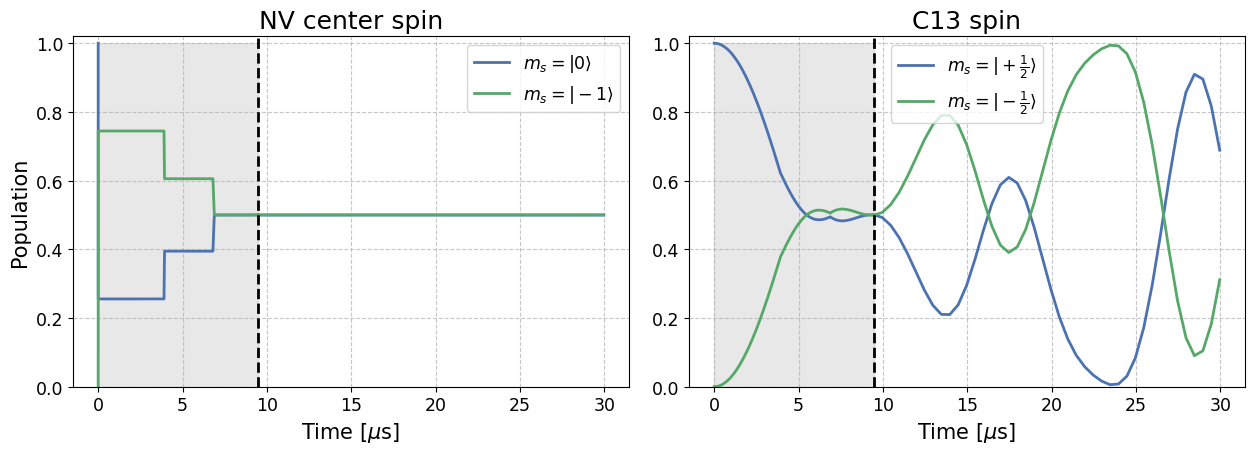

In [6]:
t_list = env.get_t_list(stepsize=0.1e-6)
t_list.extend( np.arange(env.total_time, 30e-6, 0.5e-6) )
    
new_states_full = env.get_new_states(env.pulse_seq, t_list=t_list)
new_states = new_states_full[0]
fig, ax = plot_pops(t_list, new_states, pulse_time=env.total_time)

In [ ]:
# Optimize pulse sequence 
from scipy.optimize import basinhopping, Bounds

def print_progress(x, f, accepted):
    print(f"Current parameters: {x}, Infidelity: {f}, Accepted: {accepted}")

register_C13_pos = [(0.87e-9, 0, 0.19e-9)] #, (0.56e-9, 0.77e-9, 0.31e-9), (-0.83e-9, 1.15e-9, 0.46e-9)]
bath_spin_type = 'C13'
abundancy, rmin, rmax = 0.02e-2, 2e-9, 4.2e-9
target_state = 1/np.sqrt(2) * (q.tensor(q.fock_dm(2,0), q.fock_dm(2,0)) + q.tensor(q.fock_dm(2,1), q.fock_dm(2,1)) )
init_pulse_seq = [0e-6, 4.06e-6, 1.57e-6, 1.51e-6, 1.00, 3.58, 1.68, 0.69, 1.97, 0.50]

spin_config = SpinConfig(register_C13_pos, bath_spin_type, abundancy, rmin, rmax)
system_configs = spin_config.system_configs['no_bath']

def calc_infidelity(pulse_seq):
    system = System(system_configs, [])
    pulses = Pulses(system, pulse_seq, target_state)
    return 1 - pulses.final_fidelity

basinhopping(
    calc_infidelity, init_pulse_seq, 
    minimizer_kwargs={"method": "L-BFGS-B", "bounds": Bounds([0]*10, [10e-6]*4+[np.pi]*3+[2*np.pi]*3) },
    callback=print_progress, niter=10,
)